In [1]:
%load_ext autoreload
%autoreload 2

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.sources.sympy_ode import template_model_from_sympy_odes
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model

In [2]:
# Define time variable
t = sp.symbols("t")


# Define time-dependent variables
S_h, S_r, E_h, E_r, I_h, I_r, Q, R = sp.symbols("S_h S_r E_h E_r I_h I_r Q R",
                                                cls=sp.Function)

# Define the parameters with spelled-out names
theta_h, theta_r, beta_1, beta_2, beta_3, alpha_1, alpha_2, alpha_3, \
    phi, tau, gamma, mu_h, mu_r, delta_h, delta_r, = sp.symbols(
    "theta_h theta_r beta_1 beta_2 beta_3 alpha_1 alpha_2 alpha_3 phi tau gamma mu_h mu_r delta_h delta_r"
)

N_h = S_h(t) + E_h(t) + I_h(t) + Q(t) + R(t)
N_r = S_r(t) + E_r(t) + I_r(t)


human_infection_rate = ((beta_1 * I_r(t) + beta_2 * I_h(t)) * S_h(t)) / N_h
rodent_infection_rate = (beta_3 * S_r(t) * I_r(t)) / N_r

odes = [
    sp.Eq(
        S_h(t).diff(t),
        theta_h - human_infection_rate - mu_h * S_h(t) + phi * Q(t),
    ),
    sp.Eq(
        E_h(t).diff(t),
        human_infection_rate - (alpha_1 + alpha_2 + mu_h) * E_h(t),
    ),
    sp.Eq(
        I_h(t).diff(t),
        alpha_1 * E_h(t) - (mu_h + delta_h + gamma) * I_h(t),
    ),
    sp.Eq(
        Q(t).diff(t),
        alpha_2 * E_h(t) - (phi + tau + delta_h + mu_h) * Q(t),
    ),
    sp.Eq(
        R(t).diff(t),
        gamma * I_h(t) + tau * Q(t) - mu_h * R(t),
    ),
    sp.Eq(
        S_r(t).diff(t),
        theta_r - rodent_infection_rate - mu_r * S_r(t),
    ),
    sp.Eq(
        E_r(t).diff(t),
        rodent_infection_rate - (mu_r + alpha_3) * E_r(t),
    ),
    sp.Eq(
        I_r(t).diff(t),
        alpha_3 * E_r(t) - (mu_r + delta_r) * I_r(t),
    ),
]

concept_data = {
    "S_h": {
        "identifiers": {"ido": "0000514"},
        "context": {"species": "ncbitaxon:9606"},
    },
    "E_h": {
        "identifiers": {"apollosv": "00000154"},
        "context": {
            "quarantined": "ncit:C68851",
            "species": "ncbitaxon:9606"
        },
    },
    "I_h": {
        "identifiers": {"ido": "0000511"},
        "context": {"species": "ncbitaxon:9606"},
    },
    "Q": {
        "identifiers": {"apollosv": "00000154"},
        "context": {
            "quarantined": "ncit:C71902",
            "species": "ncbitaxon:9606"
        }
    },
    "R": {
        "identifiers": {"ido": "0000592"},
        "context": {"species": "ncbitaxon:9606"},
    },
    "S_r": {
        "identifiers": {"ido": "0000514"},
        "context": {"species": "ncbitaxon:9989"},
    },
    "E_r": {
        "identifiers": {"apollosv": "00000154"},
        "context": {"species": "ncbitaxon:9989"},
    },
    "I_r": {
        "identifiers": {"ido": "0000511"},
        "context": {"species": "ncbitaxon:9989"},
    },
}


parameter_data = {
    "theta_h": {"value": 0.029*6e7},
    "theta_r": {"value": 0.2*6e5},
    "beta_1": {"value": 0.00025},
    "beta_2": {"value": 0.00006},
    "beta_3": {"value": 0.027},
    "alpha_1": {"value": 0.2},
    "alpha_2": {"value": 2.0},
    "alpha_3": {"value": 0.2},
    "phi": {"value": 2.0},
    "tau": {"value": 0.52},
    "gamma": {"value": 0.83},
    #"mu_h": {"value": 1.5},
    #"mu_r": {"value": 0.002},
    "mu_r": {"value": 1.5},
    "mu_h": {"value": 0.02},
    "delta_h": {"value": 0.2},
    "delta_r": {"value": 0.5},
}

initials = {
    "S_h": Initial(
        concept=Concept(name="S_h"),
        expression=SympyExprStr(sp.Float(6e7)),
    ),
    "E_h": Initial(
        concept=Concept(name="E_h"),
        expression=SympyExprStr(sp.Float(2000)),
    ),
    "I_h": Initial(
        concept=Concept(name="I_h"),
        expression=SympyExprStr(sp.Float(100)),
    ),
    "Q": Initial(
        concept=Concept(name="Q"),
        expression=SympyExprStr(sp.Float(10)),
    ),
    "R": Initial(
        concept=Concept(name="R"), expression=SympyExprStr(sp.Float(0))
    ),
    "S_r": Initial(
        concept=Concept(name="S_r"),
        expression=SympyExprStr(sp.Float(6e5)),
    ),
    "E_r": Initial(
        concept=Concept(name="E_r"),
        expression=SympyExprStr(sp.Float(800)),
    ),
    "I_r": Initial(
        concept=Concept(name="I_r"),
        expression=SympyExprStr(sp.Float(16)),
    ),
}


In [4]:
tm = template_model_from_sympy_odes(
    odes, param_data=parameter_data, concept_data=concept_data
)
tm.initials = initials

In [5]:
template_model_to_petrinet_json_file(tm, 'ModelB_base_petri.json')

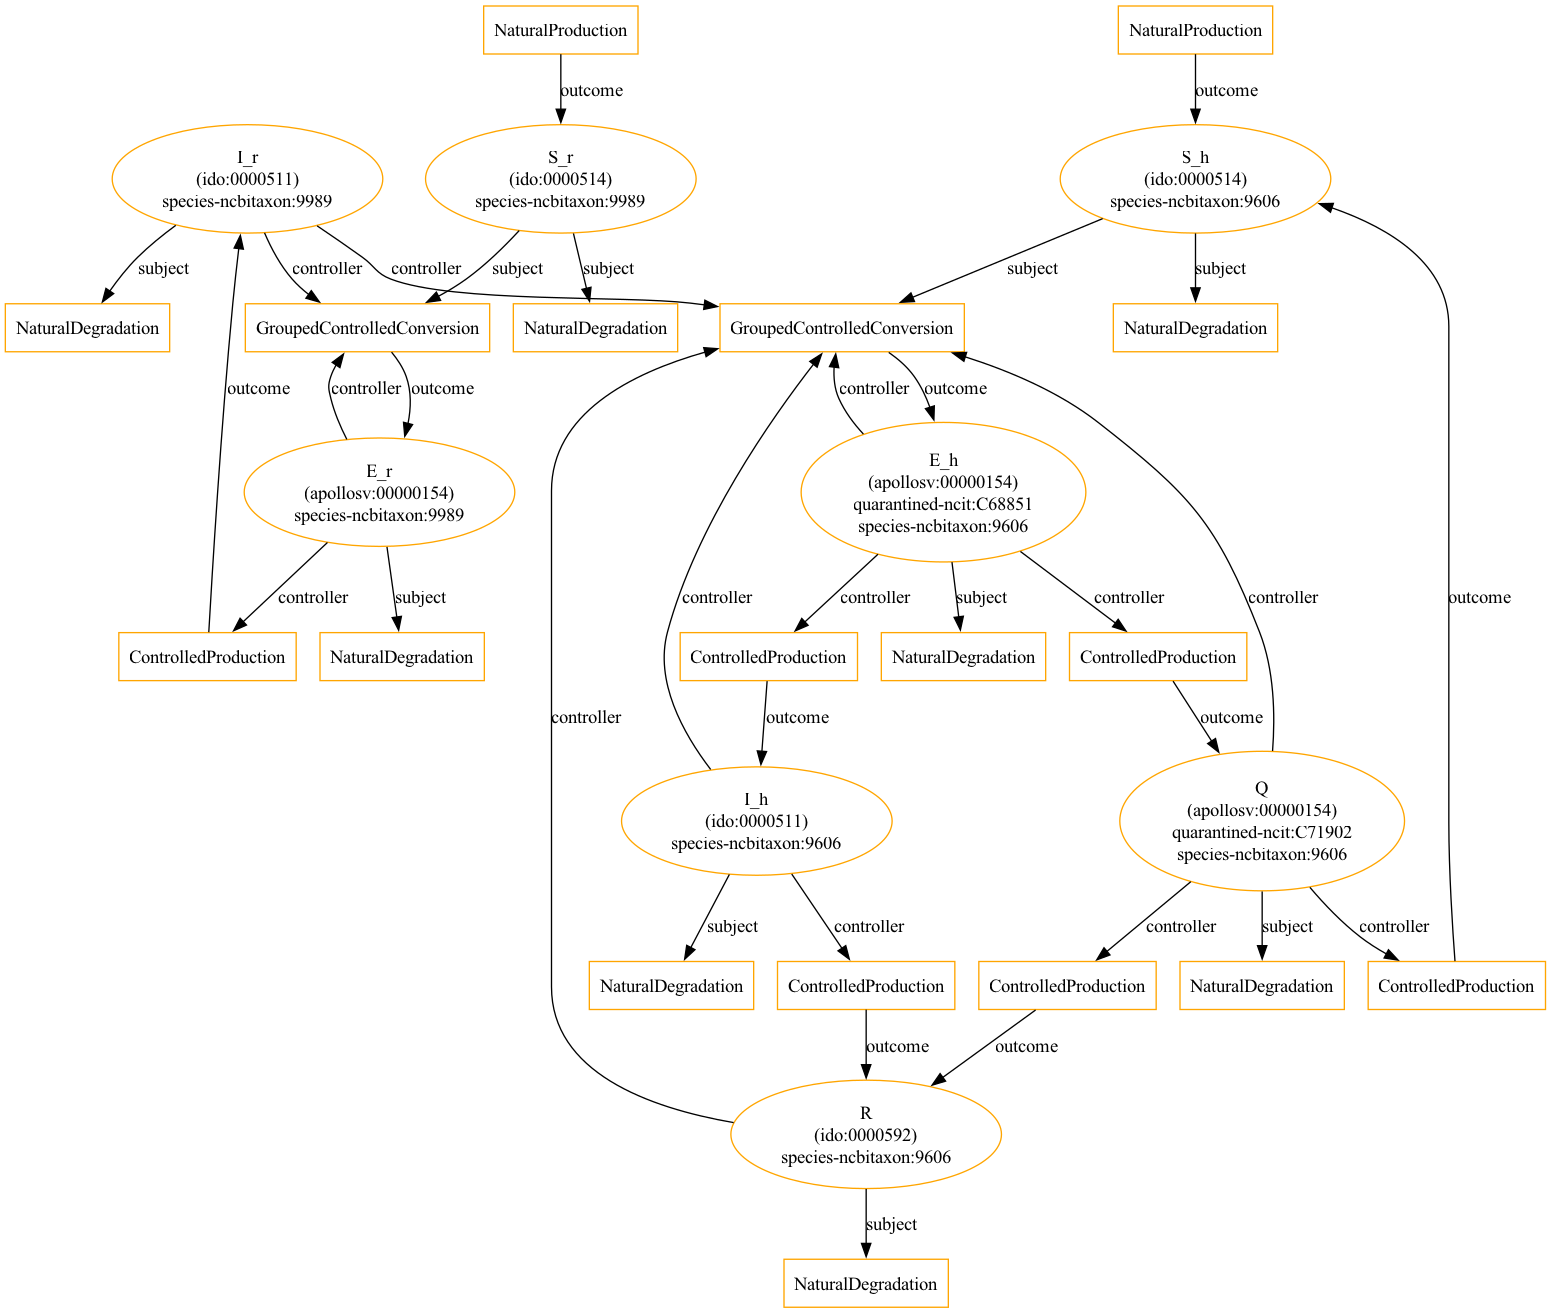

In [6]:
tm.draw_jupyter()

In [7]:
om = OdeModel(Model(tm), initialized=True)

In [8]:
om.get_interpretable_kinetics()

Matrix([
[Derivative(S_h, t), =,      Q*phi - S_h*mu_h - S_h*(I_h*beta_2 + I_r*beta_1)/(E_h + I_h + Q + R + S_h) + theta_h],
[  Derivative(Q, t), =,                                              E_h*alpha_2 - Q*(delta_h + mu_h + phi + tau)],
[Derivative(E_h, t), =, -E_h*(alpha_1 + alpha_2 + mu_h) + S_h*(I_h*beta_2 + I_r*beta_1)/(E_h + I_h + Q + R + S_h)],
[Derivative(I_r, t), =,                                                        E_r*alpha_3 - I_r*(delta_r + mu_r)],
[Derivative(I_h, t), =,                                                E_h*alpha_1 - I_h*(delta_h + gamma + mu_h)],
[  Derivative(R, t), =,                                                                I_h*gamma + Q*tau - R*mu_h],
[Derivative(S_r, t), =,                                    -I_r*S_r*beta_3/(E_r + I_r + S_r) - S_r*mu_r + theta_r],
[Derivative(E_r, t), =,                                  -E_r*(alpha_3 + mu_r) + I_r*S_r*beta_3/(E_r + I_r + S_r)]])

In [9]:
om.get_interpretable_observables()

Matrix(0, 0, [])

In [10]:
nyears = 4
times = np.linspace(0, nyears, nyears*100)
res = simulate_ode_model(om, times, with_observables=False)

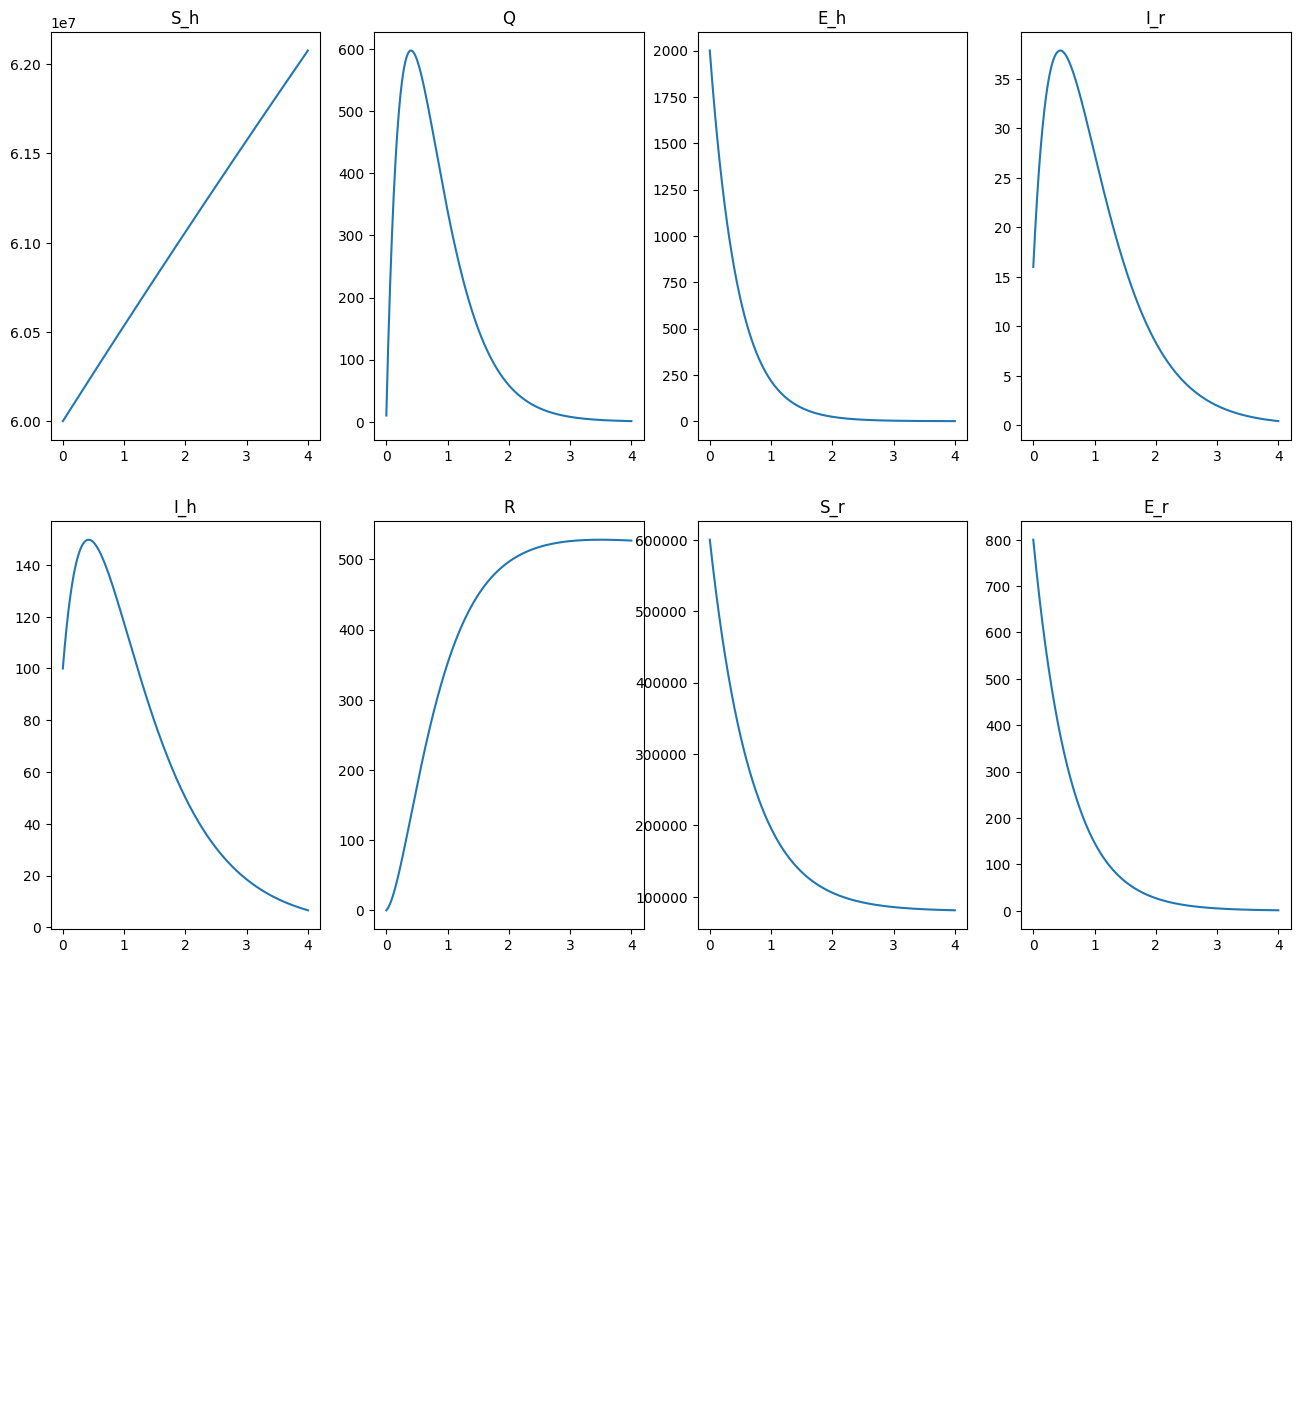

In [11]:
om.plot_simulation_results(times, res)

In [12]:
om.get_interpretable_kinetics()

Matrix([
[Derivative(S_h, t), =, 2.0*Q - S_h*(6.0e-5*I_h + 0.00025*I_r)/(E_h + I_h + Q + R + S_h) - 0.02*S_h + 1740000.0],
[  Derivative(Q, t), =,                                                                        2.0*E_h - 2.74*Q],
[Derivative(E_h, t), =,                    -2.22*E_h + S_h*(6.0e-5*I_h + 0.00025*I_r)/(E_h + I_h + Q + R + S_h)],
[Derivative(I_r, t), =,                                                                       0.2*E_r - 2.0*I_r],
[Derivative(I_h, t), =,                                                                      0.2*E_h - 1.05*I_h],
[  Derivative(R, t), =,                                                              0.83*I_h + 0.52*Q - 0.02*R],
[Derivative(S_r, t), =,                                   -0.027*I_r*S_r/(E_r + I_r + S_r) - 1.5*S_r + 120000.0],
[Derivative(E_r, t), =,                                              -1.7*E_r + 0.027*I_r*S_r/(E_r + I_r + S_r)]])

## Part 2/7

Outside of Africa, mpox is not endemic (technically, “enzootic”) in the animal population, and thus the animal parameters would be negligible. Modify the Q6 model (European Model) parameters with the relevant animal parameters set to zero. Ensure the model runs and gives plausible outputs.

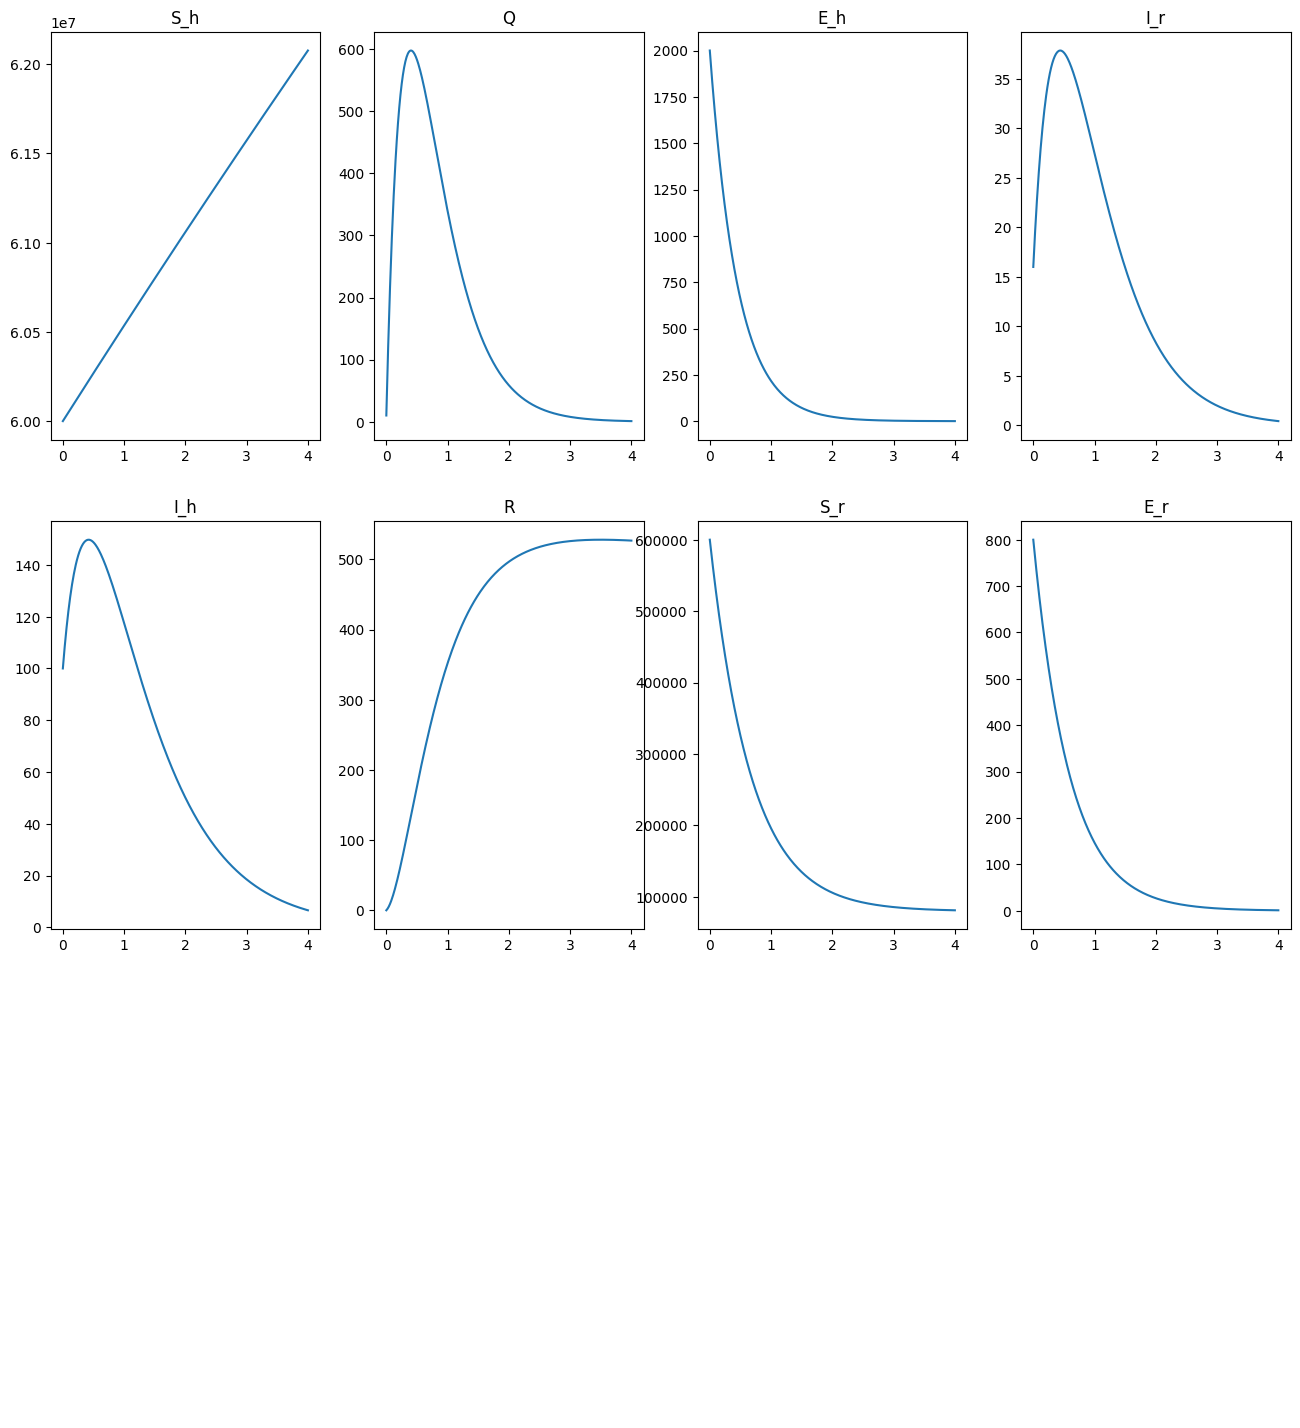

In [13]:
tm.set_parameters({'beta_1': 0})
om = OdeModel(Model(tm), initialized=True)
res = simulate_ode_model(om, times, with_observables=False)
om.plot_simulation_results(times, res)

In [14]:
om.get_interpretable_kinetics()

Matrix([
[Derivative(S_h, t), =, -6.0e-5*I_h*S_h/(E_h + I_h + Q + R + S_h) + 2.0*Q - 0.02*S_h + 1740000.0],
[  Derivative(Q, t), =,                                                         2.0*E_h - 2.74*Q],
[Derivative(E_h, t), =,                     -2.22*E_h + 6.0e-5*I_h*S_h/(E_h + I_h + Q + R + S_h)],
[Derivative(I_r, t), =,                                                        0.2*E_r - 2.0*I_r],
[Derivative(I_h, t), =,                                                       0.2*E_h - 1.05*I_h],
[  Derivative(R, t), =,                                               0.83*I_h + 0.52*Q - 0.02*R],
[Derivative(S_r, t), =,                    -0.027*I_r*S_r/(E_r + I_r + S_r) - 1.5*S_r + 120000.0],
[Derivative(E_r, t), =,                               -1.7*E_r + 0.027*I_r*S_r/(E_r + I_r + S_r)]])

## Part 2/9

In [19]:
tm.templates[12]

GroupedControlledConversion(rate_law=I_r*S_r*beta_3/(E_r + I_r + S_r), name=None, display_name=None, type='GroupedControlledConversion', controllers=[Concept(name='E_r', display_name=None, description=None, identifiers={'apollosv': '00000154'}, context={'species': 'ncbitaxon:9989'}, units=None), Concept(name='I_r', display_name=None, description=None, identifiers={'ido': '0000511'}, context={'species': 'ncbitaxon:9989'}, units=None)], subject=Concept(name='S_r', display_name=None, description=None, identifiers={'ido': '0000514'}, context={'species': 'ncbitaxon:9989'}, units=None), outcome=Concept(name='E_r', display_name=None, description=None, identifiers={'apollosv': '00000154'}, context={'species': 'ncbitaxon:9989'}, units=None), provenance=[])

In [25]:
tm.templates[12].rate_law

I_r*S_r*beta_3/(E_r + I_r + S_r)

In [24]:
S_r = tm.get_concept('S_r')
E_r = tm.get_concept('E_r')
I_h = tm.get_concept('I_h')
Q = tm.get_concept('Q')
template = ControlledConversion(
    subject=S_r,
    outcome=E_r,
    controllers=[I_h, Q]
)